# Counting objects workflow

---
*Introduction to Image Analysis Workshop*

*Stefania Marcotti (stefania.marcotti@kcl.ac.uk)*

*Intro to building image analysis pipelines with Python*

*CC-BY-SA-4.0 license: creativecommons.org/licenses/by-sa/4.0/*

---

In this notebook we will illustrate a simple workflow, consisting of a number of simple steps, designed to accomplish the goal of **counting objects in a microscopy image**. 

You will learn how to:

* Open images
* Use filters to suppress noise
* Segment images using grey level thresholding
* Count objects
* Perform basic morphological quantification

### Import libraries
Python is organised in modules and packages. To make them available in our current notebook, we use the keywork `import`. We can also import specific functions by using the syntax [`from` module `import` function]. Additionally, we can define aliases for modules' names with the keyword `as`

You can check the documentation for the various modules if you want to know more!

* [`numpy`](https://numpy.org/) - scientific computing
* [`scikit_image`](https://scikit-image.org/docs/stable/api/skimage.html) (a.k.a. [`skimage`](https://scikit-image.org/docs/stable/api/skimage.html)) - image processing and computer vision
* [`matplotlib`](https://matplotlib.org/) - visualisations
* [`pandas`](https://pandas.pydata.org/docs/user_guide/index.html) - data managing

In [1]:
import numpy as np

from skimage import io
from skimage import filters
from skimage import measure
from ngio.core import NgffImage

import matplotlib.pyplot as plt

import pandas as pd

### step 1: Create a ngff image

For this example we will use the following publicly available [image]()

In [2]:
ngff_image = NgffImage(
    "D:/The Francis Crick Dropbox/David Barry/Debugging/ome-zarr/B2-1_HhatI-10x-zset-part3_20220929_140.ome.tiff.zarr/0"
)
print(ngff_image)

# 1. Get image from highest resolution (default)
image = ngff_image.get_image()
print(image)

NGFFImage(group_path=D:\The Francis Crick Dropbox\David Barry\Debugging\ome-zarr\B2-1_HhatI-10x-zset-part3_20220929_140.ome.tiff.zarr\0/, 
          paths=['0', '1', '2', '3'], 
          labels=[], 
          tables=[], 
)
Image(group_path=D:\The Francis Crick Dropbox\David Barry\Debugging\ome-zarr\B2-1_HhatI-10x-zset-part3_20220929_140.ome.tiff.zarr\0/, 
      path=0,
      PixelSize(x=2.6, y=2.6, z=5.0, unit=micrometer),
      Dimensions(t=1, c=4, z=31, y=1367, x=1334),
)


dask.array<from-zarr, shape=(1, 4, 31, 1367, 1334), dtype=>u2, chunksize=(1, 1, 1, 1024, 1024), chunktype=numpy.ndarray>


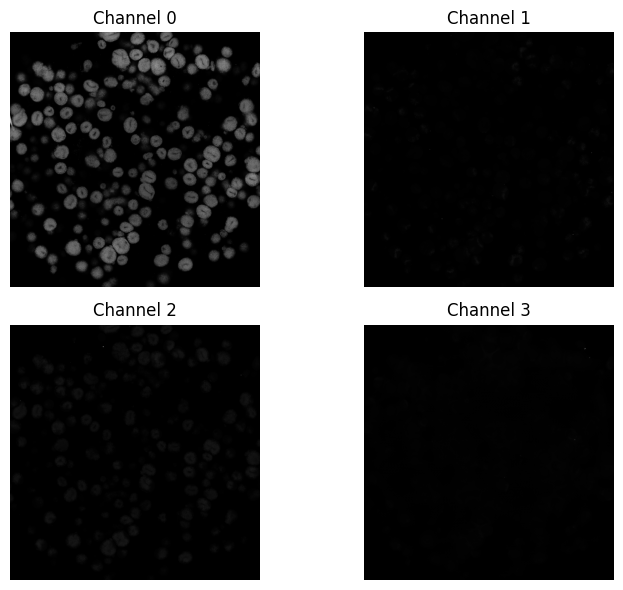

In [3]:
dask_array = image.on_disk_dask_array
print(dask_array)

# display all channels 
fig, axs = plt.subplots(2, 2, figsize=(8,6))

axs[0, 0].imshow(dask_array[0,0,15,], cmap='gray')
axs[0, 0].set_title(image.channel_labels[0])
axs[0, 0].axis('off')

axs[0, 1].imshow(dask_array[0,1,15,], cmap='gray')
axs[0, 1].set_title(image.channel_labels[1])
axs[0, 1].axis('off')

axs[1, 0].imshow(dask_array[0,2,15,], cmap='gray')
axs[1, 0].set_title(image.channel_labels[2])
axs[1, 0].axis('off')

axs[1, 1].imshow(dask_array[0,3,15,], cmap='gray')
axs[1, 1].set_title(image.channel_labels[3])
axs[1, 1].axis('off')

plt.tight_layout()

### Use filters to suppress noise

Many image processing tasks include filtering to suppress noise, improve signal-to-noise ratio, or bring out the features of the image we are interested in.

Please keep in mind that often by applying filters we change the histogram of the image, and, therefore, we won't be able to perform some quantifications related to signal intensity **after** filtering.

In this example, we are not interested in quantifying signal intensities (i.e., how bright the nuclei are), so we're good to proceed!

[`skimage`](https://scikit-image.org/docs/stable/api/skimage.html) has many filters already built in! You can find them in the submodule [`skimage.filters`](https://scikit-image.org/docs/stable/api/skimage.filters.html).

Here we'll test a [Gaussian blur](https://en.wikipedia.org/wiki/Gaussian_blur), which is a standard method to reduce image noise by blurring details. One important parameter is `sigma`, which is the standard deviation of the Gaussian kernel. You can think of it as the "size of the brush" you'll use to smooth the image features.

In [4]:
# Gaussian blur (sigma=5)
im_gauss = filters.gaussian(dask_array[:,0,], sigma=5)
print(im_gauss.shape)

(1, 31, 1367, 1334)


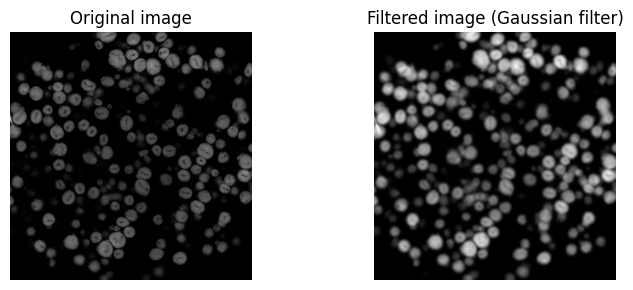

In [5]:
# display original image next to filtered one
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].imshow(dask_array[0,0,15,], cmap='gray')
axs[0].set_title('Original image')
axs[0].axis('off')

axs[1].imshow(im_gauss[0,15,], cmap='gray')
axs[1].set_title('Filtered image (Gaussian filter)')
axs[1].axis('off')

plt.tight_layout()

### Segment images using grey level thresholding

The next step in our pipeline is segmentation. This is the process by which we separate the foreground (`True`) from the background (`False`) so that the subsequent analyses are performed only on the regions of interest.

One simple way to segment images is by gray level thresholding: we "keep" all the pixels with values above a threshold (foreground) and we "discard" the rest (background).

There are different ways to set this threshold by exploiting different algorigthms. With the function [`skimage.filters.try_all_threshold`](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.try_all_threshold), we can visualise a few options and decide which one performs best for our data! [Otsu's thresholding](https://en.wikipedia.org/wiki/Otsu%27s_method) is a common choice for this type of images, so after checking its performance on the example image, we'll apply it.

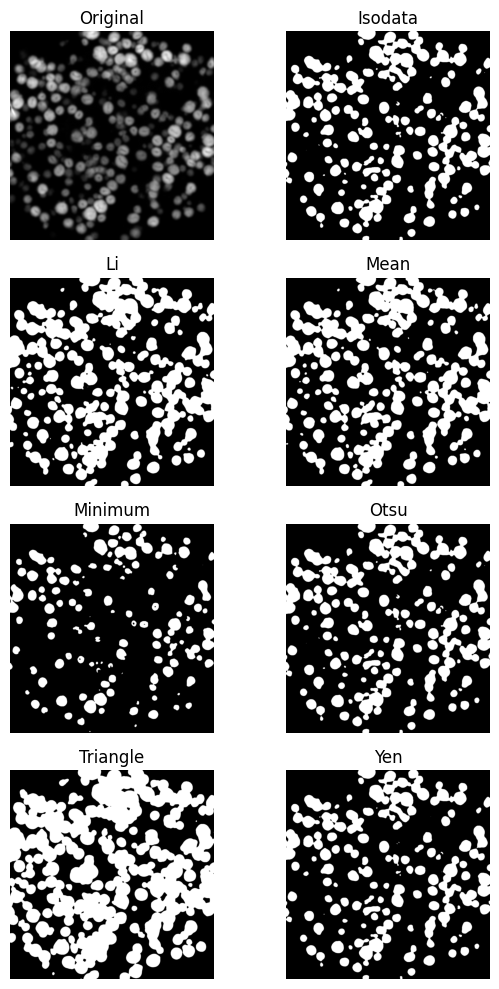

In [6]:
# display various options for gray level thresholding
fig, ax = filters.try_all_threshold(im_gauss[0,15,], figsize=(8,10), verbose=False)
plt.tight_layout()

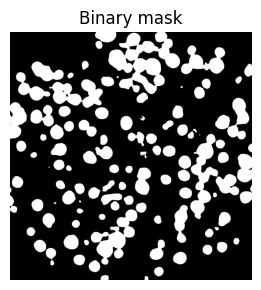

In [7]:
# Otsu thresholding performs quite well in this example, so we'll proceed by applying it to our image and display 
thresh = filters.threshold_otsu(im_gauss)
im_thresh = im_gauss >= thresh

# display the binary mask
fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(im_thresh[0,15,], cmap='gray')
ax.set_title('Binary mask')
ax.axis('off')
plt.tight_layout()

### Count objects

One way to count the objects in our thresholded image is to exploit the function [`skimage.measure.label`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.label). This function labels connected regions in the image with an integer, ultimately assigning a label to each object.

After labelling, counting the objects is equivalent to counting the number of labels available in the image!

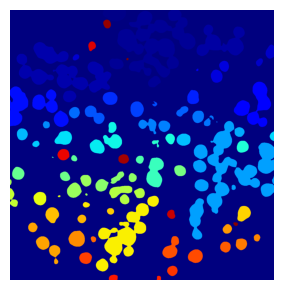

In [8]:
# label objects and visualise the result
labels = measure.label(im_thresh)

fig, ax = plt.subplots(figsize=(4,3))
ax.imshow(labels[0,15,], cmap='jet')
ax.axis('off')
plt.tight_layout()


In [9]:
# count the objects - find the maximum integer assigned to a label!
print('There are', labels.max(), 'objects in the image')

There are 96 objects in the image


## Deriving a new label

When doing image analysis, we often need to create new labels or tables. The `ngff_image` allows us to simply create new labels and tables.

In [10]:
# Create a a new label object and set it to a simple segmentation
new_label = ngff_image.labels.derive("nuclei_label", overwrite=True)
new_label.on_disk_array[...] = labels

### Image Consolidation

Every time we modify a label or a image, we are modifying the on-disk data on one layer only. 
This means that if we have the image saved in multiple resolutions, we need to consolidate the changes to all resolutions.
To do so, we can use the `.consolidate()` method.

In [11]:
label_0 = ngff_image.labels.get_label("nuclei_label", path="0")

# Consolidate the label
label_0.consolidate()

### Perform basic morphological quantification
We can perform some basic morphological quantification by using the function [`skimage.measure.regionprops_table`](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table). Check the documentation to see all the different output we can obtain!

In this example, we are going to show the area, centroid (y and x coordinates), and eccentricity for each blob. We are going to save the data in a [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which is a data structure containing labelled axes (one row for each object, one column for each feature).

In [12]:
# measure properties
props = measure.regionprops_table(labels[0,], dask_array[0,0,], properties=['area', 'centroid'])
props_df = pd.DataFrame(props)

props_df.head(5)

,area,centroid-0,centroid-1,centroid-2
0,148577.0,14.001131,22.246599,522.734044
1,1803970.0,13.414443,175.037013,723.853208
2,540420.0,12.258393,167.660827,1081.724549
3,1386321.0,14.688133,309.268080,263.622329
4,520.0,3.855769,184.536538,464.025000


In [13]:
# add image and object ID to dataframe
props_df['image_ID'] = ngff_image.root_path
props_df['label'] = props_df.index+1

props_df.head()

,area,centroid-0,centroid-1,centroid-2,image_ID,label
0,148577.0,14.001131,22.246599,522.734044,D:\The Francis Crick Dropbox\David Barry\Debug...,1
1,1803970.0,13.414443,175.037013,723.853208,D:\The Francis Crick Dropbox\David Barry\Debug...,2
2,540420.0,12.258393,167.660827,1081.724549,D:\The Francis Crick Dropbox\David Barry\Debug...,3
3,1386321.0,14.688133,309.268080,263.622329,D:\The Francis Crick Dropbox\David Barry\Debug...,4
4,520.0,3.855769,184.536538,464.025000,D:\The Francis Crick Dropbox\David Barry\Debug...,5


KeyError: 'solidity'

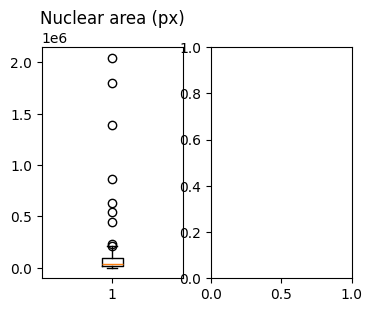

In [14]:
# display some results
fig, axs = plt.subplots(1, 2, figsize=(4,3))

axs[0].boxplot(props_df['area'])
axs[0].set_title('Nuclear area (px)')

axs[1].boxplot(props_df['solidity'])
axs[1].set_title('Nuclear solidity')

plt.tight_layout()

In [15]:
# Create a new feature table
feat_table = ngff_image.tables.new(
    name="nuc_feature_table",
    label_image="../nuclei_label",
    table_type="feature_table",
    overwrite=True,
)

feat_table.set_table(props_df)
feat_table.consolidate()

feat_table.table

print(
    f"New list of feature table: {ngff_image.tables.list(table_type='feature_table')}"
)

New list of feature table: ['nuc_feature_table']
